## Packages

In [34]:
import pandas as pd
import numpy as np
from ChernobylUtility import useful_functions as uf

import seaborn as sns
sns.set_style("dark")    # That's right
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point, Polygon
import geopandas as gpd

## Dataset and intentions

In this episode of Leo analytics, we take a look at data taken in 1986 surrounding the Chernobyl nuclear accident. The set comes from Kaggle.com at this link: https://www.kaggle.com/lsind18/chernobyl-data-air-concentration. Around 2,000 records and 11 variables make up the set. These data deal with measurements of air concentrations of dangerous radioactive isotopes sampled in european countries. We will use geographic Python packages to visualize and further understand these concentrations. But first, some background.

## Background on the affair

On April 26, 1986, the nuclear core of a power plant by the city of Pripyat, Ukraine (then a part of the U.S.S.R.) exploded. First reports say only the roof caught fire, and the incident was completely under control. Unfortunately, massive amounts of unleashed nuclear fallout would show this was actually pretty serious stuff. Soviet officials ordered evacuations of inhabited zones within a 30 km radius, the most notable of these being Chernobyl, a city 15 km south of Pripyat. The U.S.S.R., intent on showing zero weakness and incompetence, did its best to hide the issue from the western world. Wind and other natural forces, however, spread the nuclear fall out through out europe informing other countries of the big uh oh going down in Ukraine. The affair wreaked enormous damage on the environment and population. Gorbachev, the leader of the Soviet Union at the time, went so far as to say it was the real reason behind the collapse of the Soviet Union. 

## What does the data measure?

The data measures air concentrations for three radioactive isotopes: Iodine 131, Cesium 134, and Cesium 137. These were sampled in 17 different european countries. Measurements started on April 28, 1986 and continued until August 3, 1986. 

Here's a quick look at the data:

In [35]:
air = pd.read_csv('CHERNAIR.csv')

In [36]:
air.head()

,PAYS,Code,Ville,X,Y,Date,End of sampling,Duration(h.min),I 131 (Bq/m3),Cs 134 (Bq/m3),Cs 137 (Bq/m3)
0,SE,1,RISOE,12.07,55.7,86/04/27,24:00:00,24.0,1,0,0.24
1,SE,1,RISOE,12.07,55.7,86/04/28,24:00:00,24.0,0.0046,0.00054,0.00098
2,SE,1,RISOE,12.07,55.7,86/04/29,12:00,12.0,0.0147,0.0043,0.0074
3,SE,1,RISOE,12.07,55.7,86/04/29,24:00:00,12.0,0.00061,0,0.00009
4,SE,1,RISOE,12.07,55.7,86/04/30,24:00:00,24.0,0.00075,0.0001,0.00028


Each record contains the country (PAYS) and city (Ville) where the measurements for Iodine 131, Cesium 134, and Cesium 137 were taken. Latitude and longitude coordinates are encoded as X and Y. 

The genesis of our analysis began with pre-processing of the data (code is in the Preprocessing notebook). 
- PAYS and Ville are French so I changed them to their English equivalents. 
- I dropped the Code variable (a country ID code) since it would not be useful, and changed X and Y to be latitude and longitude, respectively. 
- After swimming in the data, I found out X and Y were swapped. X should have been longitude and Y should have been latitude. The person who posted the set on Kaggle must have accidentally swapped these.  
- I removed spaces from the End of sampling variable, simplified the Duration(h.min) variable, and removed spaces and concentrations from the final three radioactive isotopes. 

You can see the head of the processed data frame below.

In [37]:
air = pd.read_csv('processed_chernair.csv')

In [38]:
air.head()

,Unnamed: 0,country_code,city,longitude,latitude,Date,endsampling,duration,i131,cs134,cs137
0,0,SE,RISOE,12.07,55.7,1986-04-27,0,24.0,1.00000,0.00000,0.24000
1,1,SE,RISOE,12.07,55.7,1986-04-28,0,24.0,0.00460,0.00054,0.00098
2,2,SE,RISOE,12.07,55.7,1986-04-29,12,12.0,0.01470,0.00430,0.00740
3,3,SE,RISOE,12.07,55.7,1986-04-29,0,12.0,0.00061,0.00000,0.00009
4,4,SE,RISOE,12.07,55.7,1986-04-30,0,24.0,0.00075,0.00010,0.00028


We also take a look at the number of missing values in the set. 

In [39]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2051 non-null   int64  
 1   country_code  2051 non-null   object 
 2   city          2051 non-null   object 
 3   longitude     2051 non-null   float64
 4   latitude      2051 non-null   float64
 5   Date          2051 non-null   object 
 6   endsampling   2051 non-null   int64  
 7   duration      2051 non-null   float64
 8   i131          2009 non-null   float64
 9   cs134         1801 non-null   float64
 10  cs137         1506 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 176.4+ KB


It looks like most variables have a complete count (2051). To find the number of missing variables for the isotopes in the set, we can simply subtract the numbero non-null entries from the toal count (2051). The iodione 131 variable (i131) shows 42 missing values. Cesium 134 (cs134) has 250 missing values, and the Cesium 137 (cs137) shows 545 missing values. 

We will be visualizing these samplings on a map, and it will be interesting to see which values were missing. So, we choose to leave these NA's in the data.

## Exploratory Data Analysis 

We'll start by checking out the distribution of each isotope in our set. 

### A word on units


The original set noted Bq/m3 as the units in concentrations (see head output above). This stands for becquerels per cubic meter. A becquerel measures amount of radioactive activity. So this unit measures activity of the radioactive isotope in a cubic meter. 

Notice becquerels measure activity for an isotope. If we wanted to find out how dangerous a radioactive substance is, we need to think in terms of the ionizing radiation (radiation leaving the substance) via sieverts (sv). These units measure the dosage impact of an isotope. So how does this measure relate to a Becquerel? 

This article [1], says that being exposed to 10^6 Bq of Iodine 131 would lead to about 20 mSv. . A single one sievert (1,000 mSv) dose causes radiation sickness such as nausea, vomiting, hemorrhaging, but not death. A single dose of 5 sieverts would kill about half of those exposed to it within a month.

Outline: clean conversion. 
Tough to tell, need to compare all info for people. 
For our purposes, we will assume two things - presence is a bad sign, 

### Iodine 131

Before jumping into the concentrations numbers, it makes sense to think about why Iodine 131 is bad news. Our bodies need Iodine, particularly in the thyroid gland. The thyroid gland will pick up whatever iodine it can find in whatever form. So if one lacks iodine, and the thyroid sees a wandering radioactive 131 isotope,  the thyroid picks it up. Unfortunately, the radioactivity in the isotope can cause thyroid cancer. Around the Chernobyl incident many children in areas close to the incident lacked iodine. This is thought to have contributed to  more than 1800 cases of thyroid cancer in the area.

In [40]:
air.i131.describe()

count    2009.000000
mean        1.748547
std         5.037676
min         0.000000
25%         0.003400
50%         0.060000
75%         1.140000
max        70.000000
Name: i131, dtype: float64

Shawoah. The values in these concentrations are extremely small. It looks like most samples (third quartile) have a value up to 1.14.

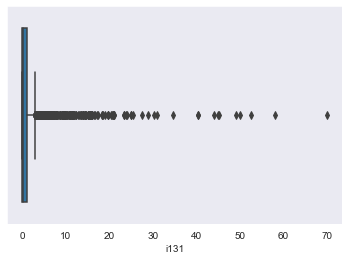

In [41]:
sns.boxplot( air.i131 )

This plot lets us know that most of the observations display small values. But for values close to zero, we don't get much information about their spread. To get a better feel for observations, we'll temporarily remove the outliers, and plot the results. 

In [42]:
# Multiple definitions for an outlier exist. We use the boxplot definition inline with our plot above.
quartiles = np.nanpercentile(air.i131, [25, 50, 75])
upper_cutoff = air.i131.mean() + 1.5 * ( quartiles[2] - quartiles[0] ) 

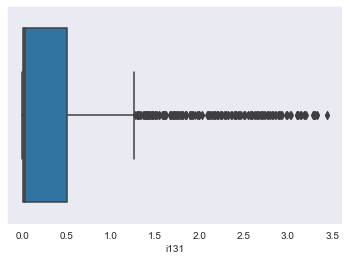

In [43]:
sns.boxplot( air.loc[ air.i131 <  upper_cutoff , 'i131'] )

This plot gives us only a slightly bit more insight into the values. It seems like most values will go up to 0.5. 

## A boring map

Originally, my sole desire was to plot samples on a static map. I wanted to agglomerate, so to speak, each country's points and visualize their spread on a map of continental europe. 

This turned out harder than I thought. 

I started by preprocessing the data. This means massaging variables into the correct formats, checking missing values, and changing variable names to be more readable. You can see the specifics in the Preprocessing jupyter notebook. 

Then, I hit the hard stuff. I started to place measurements on maps, but the measurements didn't make sense. Plots taunted me with weird readings, and eventually I found out that the data needed further preprocessing. For example, the latitude and longitude coordinates used to keep track of measurements were swapped in the original dataset. Some cities had no coordinates, and non-european countries showed up on my plots that had no business being there (e.g. Australia). You can participate in these adventures by looking at the Journey jupyter notebook. 

In [44]:
## TODO insert map of weird plots. 

The end result? A boring map of european countries showing the location of sampling measurements. See below to be almost wowed. 

In [53]:
# Create map of the world
shapefile = 'ne_50m_admin_0_countries.shp'
gdf_world = uf.read_world_map(shapefile)

In [54]:
# Read in the processed version of the data
air = pd.read_csv('air_modified.csv')

In [55]:
# Get Chernobyl data to be map friendly
gdf_air = uf.make_gdf_air( air )

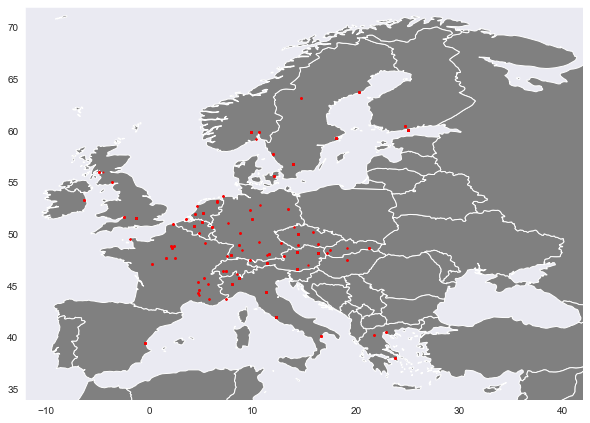

In [56]:
# Map samples on to european countries
fig, ax = plt.subplots(figsize=(10, 10))

xlim = ([-12,  42])
ylim = ([34,  72])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

gdf_world.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 1, color = 'r', alpha = 0.5)

So I arrived and thought about how the journey was better than the destination. Yes, I could see the spread of sample measurements, but the map smelled like a boring lecture. And, now that I had a visual spread of the samples more ambitious Slytherin thoughts took hold of me. 

## An interesting map

Instead of just seeing where the samples were taken, what if we could see how these measurements changed over time? Is there a way to make a more gorgeous map? What if we added zooming capabilities to the map? Seized by these questions, I discovered a *delightful* Python package named folium to aid in this new endeavor. 

In [57]:
import folium

In [58]:
# Where to center the map
CENTRAL_COORDS = [49.30481, 10.5931]     # latitude is the first coordinate
ZOOM_START = 3

In [59]:
i131_map = uf.create_folium_map( 'i131', air, CENTRAL_COORDS, ZOOM_START )

Lo and behold, a dynamic map of Iodine 131 conentration measurements. I also placed Pripyat and Chernobyl on the map (blue and gray circles). 

In [60]:
i131_map

Now you don't need Netflix because you've got this map. Pressing play forwards the measurements in time showing how they change. The legend at the top right gives an idea of how intense the conentration is at the sampling site. You can stop at any moment and click on the points to get more information on that particular point. 

## The dots speak

Now we can check out the maps for each concentration. 

We can start with the Iodine map shown originally above. Here it is again: 

In [13]:
i131_map

Most extreme (red) concentration measurements appear and stay that way until May 7. A few dots remain extreme through out the time scroll. For example, Usti, CZ shows a 1.32, and in Austria, Graz displays a whopping 9.731 after the time scroll ends. These points, however, do not indicate a constant concentration, but rather that the last measurement taken turned out extreme. (Clicking on a point will reveal the last date taken for that measurement.)   

After May 7, most points transition quickly from a strong (orange) concentration to a moderate (yellow) concentration. May 11 sees most points as moderate, but beginning to show weak (green) measures. By June 1, most dots display their final measurements and further changes in concentration will be difficult to detect just by looking at colors. 

Gray points indicate an NA, or an unavailable value. The reason for an NA could be that the site measured other radioactive elements instead of iodine. We test this hypothesis out for a particular measrument. Looking at one of the gray points in France, we find that for May 21, St. Laurent des Eaux, France, wis NA. So we look it up in our set.  

In [14]:
air.loc[air.city == 'ST.Laurent des eaux'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 493 to 512
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Unnamed: 0    20 non-null     int64   
 1   Unnamed: 0.1  20 non-null     int64   
 2   country_code  20 non-null     object  
 3   Code          20 non-null     int64   
 4   city          20 non-null     object  
 5   latitude      20 non-null     float64 
 6   longitude     20 non-null     float64 
 7   Date          20 non-null     object  
 8   endsampling   20 non-null     int64   
 9   duration      20 non-null     float64 
 10  i131          0 non-null      float64 
 11  cs134         0 non-null      float64 
 12  cs137         0 non-null      float64 
 13  geometry      20 non-null     geometry
dtypes: float64(6), geometry(1), int64(4), object(3)
memory usage: 2.3+ KB


The second column (Non-Null Count) lets us know which entries are available. Looking down at rows 10, 11, and 12 we find out that there are 0 non-nulls. In other words, no measurements for any radioactive isotope exist!

Eelde, in the Netherlands also displays an NA. We take a look at it in the original set:

In [15]:
air.loc[air.city == 'EELDE'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 918 to 933
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Unnamed: 0    16 non-null     int64   
 1   Unnamed: 0.1  16 non-null     int64   
 2   country_code  16 non-null     object  
 3   Code          16 non-null     int64   
 4   city          16 non-null     object  
 5   latitude      16 non-null     float64 
 6   longitude     16 non-null     float64 
 7   Date          16 non-null     object  
 8   endsampling   16 non-null     int64   
 9   duration      16 non-null     float64 
 10  i131          11 non-null     float64 
 11  cs134         13 non-null     float64 
 12  cs137         11 non-null     float64 
 13  geometry      16 non-null     geometry
dtypes: float64(6), geometry(1), int64(4), object(3)
memory usage: 1.9+ KB


Unlike St. Laurent des Eaux, Eelde shows 11 non-null entries in the 10 row. We can also see other entries for cs134 and cs137 (11 and 12 row). Indeed, rewinding the play back, you can see Eelde shows measurements at the beginning of May. 

## Appendix:

1. https://www.nuclear-power.net/nuclear-engineering/radiation-protection/protection-from-exposures/radioactive-contamination/airborne-contamination-particulates-noble-gases-radioiodine/
2. https://www.reuters.com/article/us-japan-quake-radiation-idUSTRE72E14R20110315